# **GPU 설정**

In [ ]:
import tensorflow as tf

# GPU 디바이스 확인
tf.test.gpu_device_name()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# TensorFlow가 GPU를 사용할 수 있도록 설정합니다.
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU is enabled')
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)


Num GPUs Available:  1
GPU is enabled


# **모듈 임포트**

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**1번 모델 개발**

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/drive/MyDrive/ColabNotebooks/프로젝트/PneumoniaClassifier/data/train')
test = get_training_data('/content/drive/MyDrive/ColabNotebooks/프로젝트/PneumoniaClassifier/data/test')
val = get_training_data('/content/drive/MyDrive/ColabNotebooks/프로젝트/PneumoniaClassifier/data/val')

<ipython-input-8-149d7cc0a3f4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 1375
Normal: 1341
Pneumonia - Normal: 34


In [ ]:
pnenumonia = 0 
normal = 0 

for i, j in val:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 8
Normal: 8
Pneumonia - Normal: 0


In [ ]:
pnenumonia = 0 
normal = 0 

for i, j in test:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 390
Normal: 234
Pneumonia - Normal: 156


PNEUMONIA


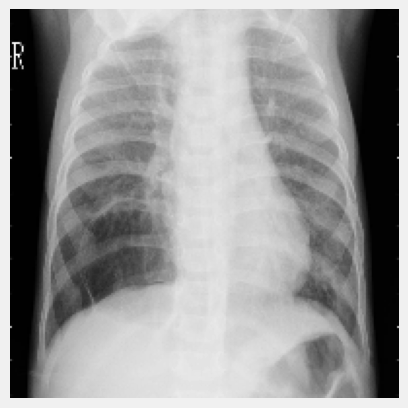

In [ ]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

In [ ]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [ ]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [ ]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('leakyrelu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('leakyrelu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('leakyrelu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('leakyrelu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))


initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 256)     2560      
                                                                 
 activation_5 (Activation)   (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 256)    0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 100, 100, 256)    400       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_6 (Activation)   (None, 100, 100, 64)     

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
375/375 [==============================] - 34s 78ms/step - loss: 0.6199 - acc: 0.7091 - val_loss: 0.5324 - val_acc: 0.7407
Epoch 2/15
375/375 [==============================] - 23s 60ms/step - loss: 0.4616 - acc: 0.7667 - val_loss: 0.3263 - val_acc: 0.8730
Epoch 3/15
375/375 [==============================] - 24s 65ms/step - loss: 0.3948 - acc: 0.8172 - val_loss: 0.3297 - val_acc: 0.8826
Epoch 4/15
375/375 [==============================] - 24s 63ms/step - loss: 0.3734 - acc: 0.8305 - val_loss: 0.2427 - val_acc: 0.9136
Epoch 5/15
375/375 [==============================] - 23s 60ms/step - loss: 0.3229 - acc: 0.8634 - val_loss: 0.2520 - val_acc: 0.9039
Epoch 6/15
375/375 [==============================] - 23s 62ms/step - loss: 0.2954 - acc: 0.8796 - val_loss: 0.2123 - val_acc: 0.9264
Epoch 7/15
375/375 [==============================] - 23s 62ms/step - loss: 0.2844 - acc: 0.8855 - val_loss: 0.2319 - val_acc: 0.8965
Epoch 8/15
375/375 [==============================] - 23s 62ms

In [ ]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 2s 66ms/step - loss: 0.1979 - acc: 0.9343


[0.19789612293243408, 0.9343003630638123]

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()


In [ ]:
 model.save('model.h5')

#**2번 모델 개발**

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
  '/content/drive/MyDrive/ColabNotebooks/프로젝트/PneumoniaClassifier/data/train',
  target_size=(200, 200),
  color_mode='grayscale',
  batch_size=1,
  class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
  '/content/drive/MyDrive/ColabNotebooks/프로젝트/PneumoniaClassifier/data/test',
  target_size=(200, 200),
  color_mode='grayscale',
  batch_size=1,
  class_mode='categorical'
)

Found 2716 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.applications import InceptionV3

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = InceptionV3(include_top=True,
                    weights=None,
                    input_shape=(200, 200, 1),
                    pooling=max,
                    classes=2,
                    classifier_activation="softmax")

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'],
              optimizer=Adam(learning_rate=lr_schedule))

model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    batch_size=16,
                    callbacks=[early_stop])


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_752 (Conv2D)            (None, 99, 99, 32)   288         ['input_9[0][0]']                
                                                                                                  
 batch_normalization_752 (Batch  (None, 99, 99, 32)  96          ['conv2d_752[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [1]:
model.save('model2.h5')

plt.figure(figsize=(24,8))

plt.subplot(2,2,1)
plt.plot(history.history['loss'],'b-',label='loss')
plt.plot(history.history['val_loss'],'r--',label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'],'g-',label='accuracy')
plt.plot(history.history['val_accuracy'],'k--',label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.4,1.0)
plt.legend()

NameError: ignored

In [3]:
f = "/content/drive/MyDrive/ColabNotebooks/프로젝트/PneumoniaClassifier/model.h5"
model = tf.keras.models.load_model(f)

NameError: ignored

In [ ]:
f = "/content/drive/MyDrive/ColabNotebooks/프로젝트/PneumoniaClassifier/model2.h5"
model2 = tf.keras.models.load_model(f)

In [ ]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)

pred2 = model2.predict(X_train)
precisions2, recalls2, thresholds2 = precision_recall_curve(y_train, pred)

68/68 [==============================] - 3s 41ms/step


ValueError: ignored

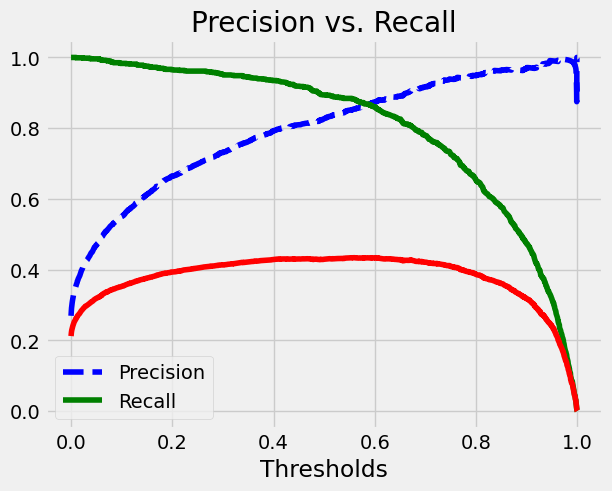

In [ ]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.plot(thresholds, (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1]), 'r-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

    
plot_precision_recall(precisions, recalls, thresholds)
plot_precision_recall(precisions2, recalls2, thresholds2)


In [ ]:
predictions = (model.predict(X_test) * 0.8 + model2.predict(X_test) * 0.2)

37/37 [==============================] - 2s 41ms/step


In [ ]:
binary_predictions = []
threshold = (0.8 * thresholds[np.argmax(precisions >= 0.80)] + thresholds2[np.argmax(precisions >= 0.80)] * 0.2)
print(threshold)
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
print('F1 score on testing set:', 2 / (1 / precision_score(binary_predictions, y_test) + 1 / recall_score(binary_predictions, y_test)))

Accuracy on testing set: 0.9232081911262798
Precision on testing set: 0.9422492401215805
Recall on testing set: 0.8136482939632546
F1 score on testing set: 0.8732394366197184


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

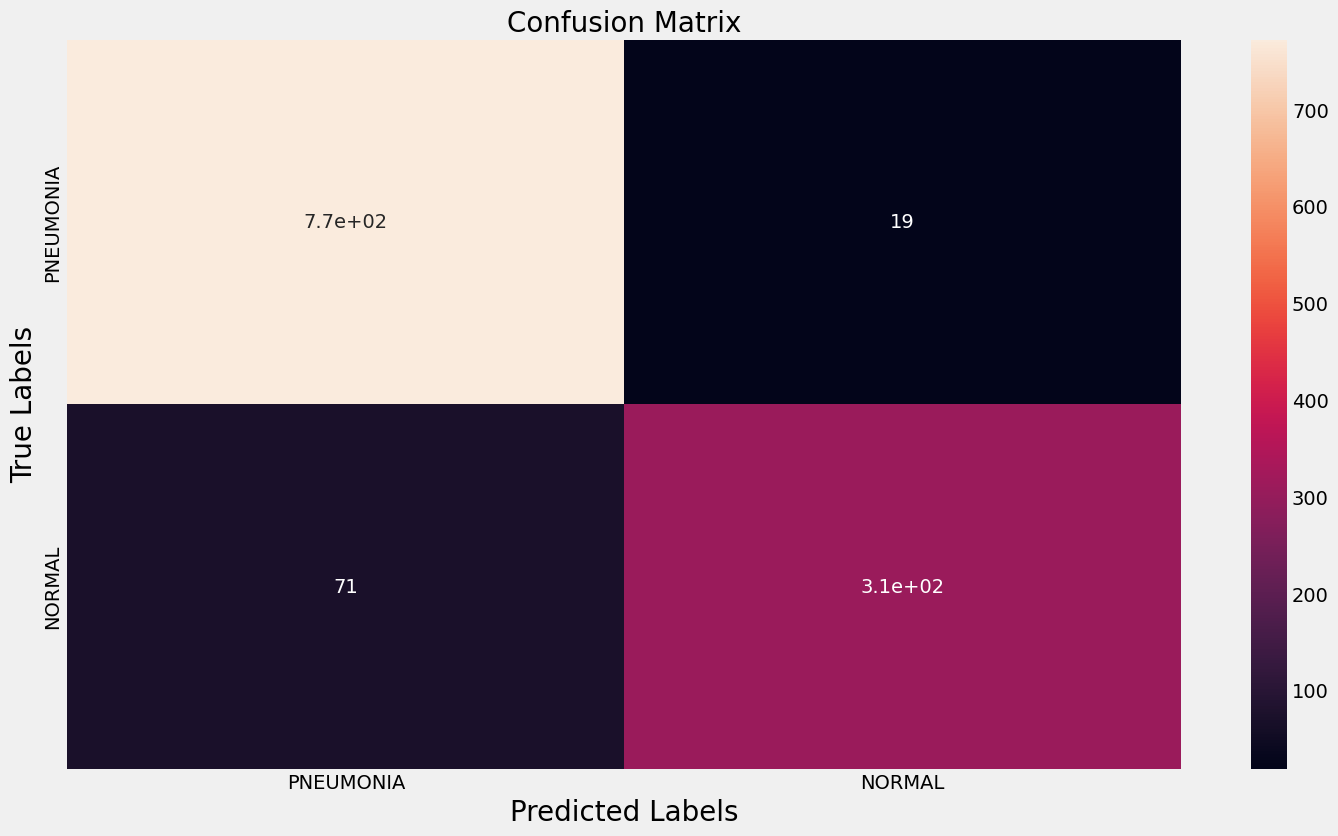

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

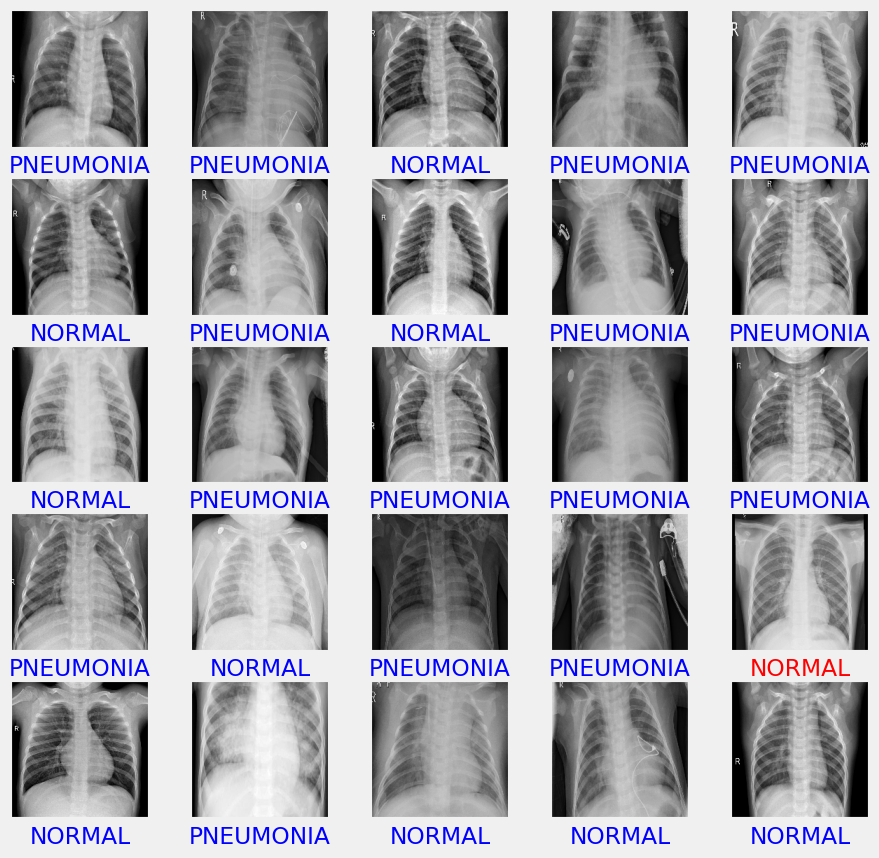

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()